In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

import safe_learning
import plotting

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Problem definition

We define a reinforcement learning problem with piecewise linear function approximators. These rely on a regular discretization of the grid into cells.

In [2]:
domain = [[-1.2, 0.7], [-.07, .07]]
n_points = [20, 20]

# Define a discretization on the domain
discretization = safe_learning.GridWorld(domain, n_points)

# Value function is piecewise linear
value_function = safe_learning.Triangulation(discretization, np.zeros(discretization.nindex), project=True,
                                             name='tri_value_function')

# Policy is piecewise linear and saturated
policy = safe_learning.Triangulation(discretization, np.zeros(discretization.nindex), project=True,
                                     name='tri_policy')
policy = safe_learning.Saturation(policy, -1., 1.)

# Discount factor
gamma = .99
terminal_reward = 1 - gamma

@safe_learning.utilities.with_scope('true_dynamics')
def dynamics(states, actions):
    """Return future states of the car"""    
    x0 = states[:, 0] + states[:, 1]
    x1 = states[:, 1] + 0.001 * actions[:, 0] - 0.0025 * tf.cos(3 * states[:, 0])
    
    return tf.stack((x0, x1), axis=1)


@safe_learning.utilities.with_scope('reward_function')
def reward_function(states, actions):
    """Reward function for the mountain car"""
    zeros = tf.zeros((states.shape[0], 1), tf.float64)
    ones = tf.ones_like(zeros)
    # Reward is zero except at terminal states
    return tf.where(tf.greater(states[:, 0], 0.6), terminal_reward * ones, zeros)


## Define the policy optimization problems

Based on the dynamics we define the tensorflow operations to optimize the policy.

In [3]:
# Define the reinforcement learning setup
rl = safe_learning.PolicyIteration(
    policy,
    dynamics,
    reward_function,
    value_function,
    gamma=gamma)

# Create a tensorflow session
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())

# Optimize over policy variables
with tf.name_scope('dynamics_programming'):
    # For triangulations we can solve a linear programm to determine the value function
    # value_opt = rl.value_iteration()
    value_opt = rl.optimize_value_function()
    
    # The policy is optimized using gradient descent
    policy_loss = -1 / (1-gamma) * tf.reduce_mean(rl.future_values(rl.state_space))

    optimizer = tf.train.GradientDescentOptimizer(1.)
    adapt_policy = optimizer.minimize(policy_loss,
                                      var_list=[rl.policy.parameters])


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [4]:

old_values = np.zeros_like(rl.value_function.parameters[0].eval())
old_actions = np.zeros_like(rl.policy.parameters[0].eval())
converged = False
action_space = np.array([[-1.], [1.]])


for i in range(30):
    # Optimize value function
    value_opt.eval()

    # Optimize policy (discrete over grid or gradient descent)
    # rl.discrete_policy_optimization(action_space)
    for _ in range(200):
        session.run(adapt_policy)

    # Get new parameters
    values, actions = session.run([rl.value_function.parameters[0],
                                  rl.policy.parameters[0]])

    # Compute errors
    value_change = np.max(np.abs(old_values - values))
    actions_change = np.max(np.abs(old_actions - actions))

    # Break if converged
    if value_change <= 1e-1 and actions_change <= 1e-1:
        converged = True
        break
    else:
        old_values = values
        old_actions = actions


if converged:
    print('converged after {} iterations. \nerror: {}, \npolicy: {}'
          .format(i + 1, value_change, actions_change))
else:
    print('didnt converge, error: {} and policy: {}'
          .format(value_change, actions_change))

converged after 16 iterations. 
error: 0.0016688119951481228, 
policy: 0.06848239569777015


# Plot the resulting value function and policy

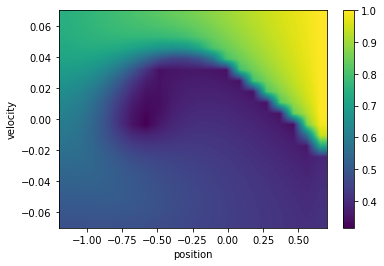

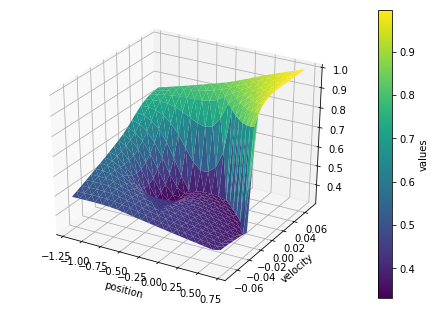

In [5]:
plotting.plot_triangulation(rl.value_function, xlabel='position', ylabel='velocity')
plt.show()

plotting.plot_triangulation(rl.value_function, three_dimensional=True,
                            xlabel='position', ylabel='velocity', zlabel='values')
plt.show()

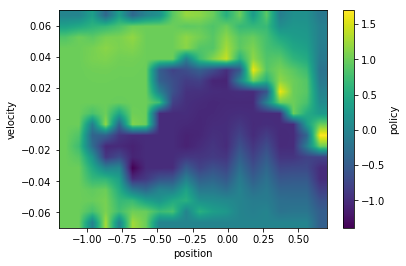

In [6]:
plotting.plot_triangulation(rl.policy, zlabel='policy', xlabel='position', ylabel='velocity')
plt.show()

# Visualize the trajectory

In [7]:
with tf.name_scope('compute_trajectory'):
    states = np.zeros((1000, 2), dtype=np.float)
    states[0, 0] = -0.5

    state = tf.placeholder(tf.float64, [1, 2])
    next_states = rl.dynamics(state, rl.policy(state))

In [8]:
# Compute the trajectories.
for i in range(len(states) - 1):
    states[i+1, :] = next_states.eval(feed_dict={state: states[[i], :]})

    # break if terminal
    if states[i+1, 0] >= 0.6:
        states[i+1:] = states[i+1]
        break

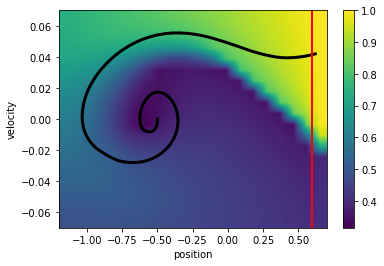

In [9]:
ax = plotting.plot_triangulation(rl.value_function, xlabel='position', ylabel='velocity')
ax.plot(states[:,0], states[:, 1], lw=3, color='k')
ax.plot(np.ones(2) * 0.6, ax.get_ylim(), lw=2, color='r')

plt.show()

# Visualize the computation graph

In [10]:
plotting.show_graph(tf.get_default_graph())